In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import warnings
from sklearn import datasets
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

### CART Algorithm
***
##### &emsp;1.CART for classification trees
l'implementation de l'algorithme et fait en étapes expliquées en commentaires :

&emsp;1.extraire les points de divisions de chaque variable 

&emsp;2.calculer lindice de Gini pour chaque noeud de division $g_1$ et $g_2$ $$g_i = \sum_{i\neq j} p_i*pj \text{  |  }  p_i =\frac{\text{nombre de 0 ou 1}}{total} $$ 

&emsp;3.calculer lindice de Gini pour chaque division $g_1$ Gini du noeud et $P_1$ poids du noeud $$G = g_1P_1 + g_2P_2$$ 

&emsp;4.chercher la meilleure division qui minimise Gini 

&emsp;5.diviser et repeter jusqu'a arriver a la longeur maximale ou taille minimale

&emsp;6.predire $$\bar y = argmax(P(j \backslash t))$$

Base de données 

In [2]:
data = pd.read_csv('https://sololearn.com/uploads/files/titanic.csv')
data.Sex = data.Sex.apply(lambda x : 1 if x == "male" else 0 )

X,y = data,data.Survived

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2 ,random_state= 5
    )
data.head(5)

,Survived,Pclass,Sex,Age,Siblings/Spouses,Parents/Children,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


##### Construction de l'arbre

In [3]:
#Definition de la class Cart 
class Cart_classification :
    #initialisation des attribut de la class
    def __init__(self, data: pd.DataFrame, y:str , depth=0) :
        #la base de donnée
        self.data = data 
        
        #le nom de la variable dépendante
        self.label = y
        
        #longueur de l'arbre
        self.depth = depth
        
        # X représente les variables indépendantes (apres avoir éliminer y)
        self.X = data.drop(y,axis = 1)
        
        # y comme une list la variable a prédire (as a list pour pouvoir utiliser la fonction "count()") 
        self.y = list(data[y])
        
        #list des noms des colonnes pour les iterations  
        self.features = list(self.X.columns)
        
        #cas de classification counts represente le nombre de "0" et "1" dans y 
        self.counts = self.get_counts(self.y)
        
        #num_samples = le nombre d'observation
        self.num_samples = len(self.y)
        
        #prediction par la valeur la plus presente "argmax"
        self.predicted_label = np.argmax(self.counts)
        
        #initialisation des noeux enfants gauche et droit
        self.left = None
        self.right = None
    
    #La méthode "get_counts" calcul le nombre de 0 et 1 dans la variable y pour chaque division de noeud     
    def get_counts(self,y : list):
        return [y.count(i) for i in range(2)]
    
    #La methode "get gini" calcul l'indice de Gini pour un échantillon   
    def get_gini(self, n):
        #total le nombre d'observations dans l’échantillon 
        total = n[0] + n[1]
        # p : probabilté d'avoir un 0
        p = n[0] / total
        # q : probabilité d'avoir un 1 (q = nombre des uns /total)
        q = 1 - p                
        return  p * (1 - p) + q * (1 - q) # calcul de l'indice de gini
    
    #La méthode "get_possible_splits" boucle dans chaque variables pour extraire toutes les valeurs possibles pour diviser le noeud racine (split point)
    def get_possible_splits(self, feature : str):
        values = np.unique(self.X[feature])
        return (values[1:] + values[:-1]) / 2   
    
    #La méthode "get_split_gini" calcul l'indice de Gini pour chaque noeud enfant
    def get_split_gini(self , feature:str , split_point):
        #left pour les valeurs moins que le point de division et right pour les valeus plus
        left = self.data[self.data.apply(lambda x: x[feature] < split_point,axis=1)]
        right = self.data.drop(left.index)
        
        #nombre d'observation
        total = self.data.shape[0]
        
        #calcul du nombre de 0 et 1 pour les deux noeux enfants apres la division en utilisant la méthode prédéfinie "get_counts"
        n_right = self.get_counts(right[self.label].to_list())
        n_left = self.get_counts(left[self.label].to_list())
        
        #poids de chaque noeud (probabilté d'etre > point de division ou < )
        p_right = len(right) / total
        p_left = 1 - p_right
        
        #calcul de l'indice de Gini pour les deux noeux enfants en utilisant la méthode prédéfinie "get_gini"
        gini_right = self.get_gini(n_right)
        gini_left = self.get_gini(n_left)
        
        return (gini_left * p_left) + (p_right * gini_right) #return l'indice de Gini globale 
    
    #La méthode "get_opt_split" cherche la meilleur division en calculant l'indice de Gini pour chaque valeurs de divisions dans chaque variable puis prendre le minimum Gini
    def get_opt_split(self):
        #commancant par aucune valeur optimale (les deux variables seront utilisés comme argumment pour la methode de division)
        opt_feature , opt_split = None, None
        
        variables = []             #list vide pour sauvegarder les variable apres chaque iteration
        splits = []                #list vide pour sauvegarder les valeurs de divisions apres chaque iteration
        gini_values = []           #list vide pour sauvegarder les indice de gini pour chaque point apres chaque iteration
        
        #extraire les point de divisions possibles pour chaque variables dans la base de donnée en utilisant la méthode "get_possible_splits"
        for feature in self.features :
            possible_splits = self.get_possible_splits(feature)
            
            #apres pour chaque point de division en calcul l'indice de Gini global 
            for split in possible_splits :
                split_gini = self.get_split_gini(feature, split)
                #l'idée est de sauvegarder apres chaque etape la variable et le point de division et sont indice de Gini dans des lists distinct pour qu'ils aient le meme index 
                gini_values.append(split_gini)
                splits.append(split)
                variables.append(feature)
                #apres prendre l'index du minimum Gini
                opt_gini_idx=gini_values.index(min(gini_values))
                #et sauvegarder le point de de division optimale de la variable optimale qui correspond
                opt_feature , opt_split = variables[opt_gini_idx] , splits[opt_gini_idx]
        return opt_feature , opt_split    
    
    #La méthode "make_split" divise le noeud racine en noeud gauche et droite par rapport au valeurs optimales obtenues par la dernière methode "get_opt_split"
    def make_split(self, max_depth, min_samples_split):
        self.opt_feature , self.opt_split = self.get_opt_split()
        if self.opt_feature is not None : 
            #Condition d'arret (avoid over fitting) 
            if (self.depth < max_depth) & (min_samples_split < self.num_samples):
                
                #diviser la base de donnée a chaque fois jusqu'a atteindre la longueur maximale ou pas assez d'observations 
                left = self.data[self.data.apply(lambda x: x[self.opt_feature] < self.opt_split,axis=1)]
                right = self.data.drop(left.index)
                
                #a chaque fois on ajoute +1 pour la longueur 
                self.left = Cart_classification(left, self.label, self.depth + 1)
                self.right = Cart_classification(right, self.label, self.depth + 1)
                
                #repetter la division 
                self.left.make_split(max_depth,min_samples_split)
                self.right.make_split(max_depth,min_samples_split)

Example d'une methode de la class cart_classification

In [4]:
cart = Cart_classification(data,"Survived")
cart.get_possible_splits("Age")[:10]

array([0.545, 0.71 , 0.79 , 0.875, 0.96 , 1.5  , 2.5  , 3.5  , 4.5  ,
       5.5  ])

##### Fitting and Prediction

In [5]:
#Définition de la class Decision_tree pour train et pour predictions               
class Decision_Tree_Classifier : 
    #initialisations des attributs
    def __init__(self, y, max_depth, min_samples_split) :
        self.max_depth= max_depth    # maximum longueur de l'arbre
        self.min_samples_split = min_samples_split    #minimum nombre d'observation pour faire la division
        self.y = y
    
    #train the model 
    def train(self, train) : 
        #créer un objet de class cart
        self.root = Cart_classification(train, self.y) 
        #diviser la base de donnée en noeux           
        self.root.make_split(self.max_depth, self.min_samples_split)
    
    #prediction     
    def predict(self, X):
        predictions = []
        #itteration par chaque ligne de la base de données
        for idx , row in X.iterrows():
            #créer le noeud racine
            node = self.root 
            #repeter classifier xi tanque la longeur maximum n'est pas atteinte
            while node.depth < self.max_depth :
                if node.num_samples < self.min_samples_split:
                    break
                split_feature , split_point = node.opt_feature,node.opt_split

                #arreter si pas de division possible
                if split_feature is None : 
                    break
                #si xi < seuil classifier a gauche sinon a droite    
                else : 
                    if row[split_feature] < split_point : 
                        node = node.left
                    else : 
                        node = node.right
                #prediction par argmax (attribut : predicted_label)
            predictions.append(node.predicted_label)
        return predictions

Fitting the model

In [6]:
model= Decision_Tree_Classifier(y="Survived",max_depth=5,min_samples_split=20)
model.train(X_train)

Exemple de prediction sur l'ensemble de test 

In [7]:
model.predict(X_test)[:25]

[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]

In [8]:
#un plus matrice de confusion   
def Confusion_matrix(y_pred, y_true):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            tp += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
    
    data = {'Actual Positive': [tp, fn], 'Actual Negative': [fp, tn]}
    index = ['Predicted Positive', 'Predicted Negative']
    
    return pd.DataFrame(data, index=index)    

#accuracy
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

##### Performance du model 
Matrice de confusion

In [9]:
Confusion_matrix(model.predict(X_test),list(y_test))

,Actual Positive,Actual Negative
Predicted Positive,44,9
Predicted Negative,23,102


Accuracy

In [10]:
print(f"Accuracy of the model {accuracy(y_test,model.predict(X_test))}")

Accuracy of the model 0.8202247191011236


##### &emsp;2.CART for regression trees

&emsp; Le meme algorithme de la classification sauf que on calcul la variance et non pas l'indice de Gini et le choix de la division optimale par reduction de la variance initiale i.e la division qui minimise la variance $$\Delta R(t,\delta) = R(t) - R(t_g) - R(t_d)$$ 

Base de données 

In [11]:
data = pd.read_csv('airfoil_self_noise.dat', sep='\t',names=["x1","x2","x3","x4","x5","y"])
X = data
Y = data.y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=5)
data.head(5)

,x1,x2,x3,x4,x5,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


##### Construction de l'arbre

In [12]:
class Cart_regression :
    
    def __init__(self, data, y, depth=0) :
        self.data = data 
        self.label = y
        
        self.depth = depth
        
        self.X = data.drop(y,axis = 1)
        self.y = list(data[y])
        self.features = list(self.X.columns)
        
        #variance de la variable y initiale a minimiser 
        self.variance = self.get_variance(self.y)
        
        self.num_samples = len(self.y)
        
        #prediction par la moyenne des valeur sur le noeud terminal 
        self.predicted_label = np.mean(list(self.y))
        
        self.left = None
        self.right = None
        
    def get_variance(self, y):
        return np.var(y)
    
    def get_possible_splits(self, feature):
        return np.unique(self.X[feature])
         
    
    def get_split_variance(self , feature , split_point):
        left = self.data[self.data[feature] < split_point ]
        right = self.data.drop(left.index)
        
        right_var = self.get_variance(right[self.label].to_list())
        left_var = self.get_variance(left[self.label].to_list())
        
        p_right = len(right)/ self.data.shape[0]
        p_left = 1 - p_right
        
        # R(tg) = (p_left * left_var)           R(t_r) = (p_right * right_var)
        return (p_left * left_var) + (p_right * right_var)
    
    def get_opt_split(self):
        opt_feature , opt_split = None, None
        opt_var = 0
        
        for feature in self.features :
            possible_splits = self.get_possible_splits(feature)
            for split in possible_splits :
                split_var = self.get_split_variance(feature, split)
                var_reduction = self.variance - split_var
                
                if var_reduction > opt_var : 
                    opt_var = var_reduction 
                    opt_feature , opt_split = feature , split
        return opt_feature , opt_split    
    
    def make_split(self, max_depth, min_samples_split):
        self.opt_feature , self.opt_split = self.get_opt_split()
        if self.opt_feature is not None : 
            if (self.depth < max_depth) & (min_samples_split < self.num_samples):
                
                left = self.data[self.data[self.opt_feature] < self.opt_split ]
                right = self.data.drop(left.index)
                
                self.left = Cart_regression(left, self.label, self.depth + 1)
                self.right = Cart_regression(right, self.label, self.depth + 1)
                
                self.left.make_split(max_depth,min_samples_split)
                self.right.make_split(max_depth,min_samples_split)
       

Exemples de methode et attributs de la class cart_regression

In [13]:
cart = Cart_regression(data,"y")
cart.variance #variance de y initiale

47.559798869646826

In [14]:
cart.get_split_variance("x4",50) 

46.65080293116911

##### Fitting and Prediction

In [15]:
             
class Decision_Tree_Regressor : 
    def __init__(self, y, max_depth, min_samples_split) :
        self.max_depth= max_depth    
        self.min_samples_split = min_samples_split    
        self.y = y

    def train(self, train) : 
        self.root = Cart_regression(train, self.y)            
        self.root.make_split(self.max_depth, self.min_samples_split)
      
    def predict(self, X):
        predictions = []
        for idx , row in X.iterrows():
            node = self.root 
            while node.depth < self.max_depth :
                if node.num_samples < self.min_samples_split:
                    break
                split_feature , split_point = node.opt_feature,node.opt_split
                
                if split_feature is None : 
                    break
                else : 
                    if row[split_feature] < split_point : 
                        node = node.left
                    else : 
                        node = node.right
                #prediction par moyenne 
            predictions.append(node.predicted_label)
        return predictions

Fitting

In [16]:
model = Decision_Tree_Regressor(y="y",max_depth=5,min_samples_split=20)
model.train(X_train)

Predictions example

In [17]:
pd.DataFrame({"y_pred":[np.round(x,2) for x in model.predict(X_test)],"y_true": Y_test})

,y_pred,y_true
1039,133.98,134.996
343,116.71,114.249
1405,118.82,119.350
521,116.71,121.944
199,112.98,114.984
...,...,...
890,126.68,127.220
919,126.68,121.225
679,126.68,128.809
1484,115.86,118.998


##### Performance

In [18]:
mean_squared_error(Y_test,model.predict(X_test))

19.317833150292252

### Adaboost 
*** 

étape 1 - L'algorithm commance par creer un weak learner $h_t(x)$ un arbre de décision à un noeud qui prédit 1 si inférieur à un seuil et -1 sinon 

étape 2 - on calcul les poids des observations appelés w $$w(x_i,y_i) = \frac{1}{N}, i= 1,2,....n $$ 

étape 3 - comme CART chercher le meilleur weak-learner en minimisant l'erreur $$\epsilon = \sum{w_{i,t}}$$
étape 4 - calculer la performances des models $$\alpha = 0.5 * ln(\frac{1-\epsilon}{\epsilon})$$

étape 5 - mettre a jours les poids w et normaliser $$w_{i,t+1} = w_{i,t}e^{-y_i\alpha_t h_t}$$ $$\sum{w}=1$$
étape 6 - ajouter le model à l'ensemble $$F_t(x) = F_{t-1}(x)+\alpha_t h_t(x)$$



Base de données

In [32]:
data = datasets.load_breast_cancer()
 
X, y = pd.DataFrame(data.data), pd.DataFrame(data.target).iloc[:,0]

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5
)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [33]:
#creation de la class weak learner pour creer des arbres de decicions a 1 noeux  
class Weak_learner() : 
#### étape 1
    def __init__(self,feature=None, split_point=None, decision = "yes"):
        # arguments : la variable et le point de devision
        self.feature = feature
        self.split_point = split_point
        
        #decision si on donne 1 pour la valeur supérieur ou inférieur au point de division 
        self.decision = decision
        
    def predict(self, X):
        #prediction simple 1 si l'observation inferieur au seuil -1 sinon
        if self.decision == "yes":
            predictions = [1 if i < self.split_point else -1 for i in X.iloc[:,self.feature]]
        else :
            predictions = [1 if i > self.split_point else -1 for i in X.iloc[:,self.feature]]
        predictions = np.array(predictions)

        return predictions
    
class Adaboost():
    #initialisation des parametres 
    def __init__(self,n_trees, alpha=None):
        #nombre de weak learners (stump trees)
        self.n_trees = n_trees
        
        #list pour sauvegarder les arbres de decisions
        self.classifiers = []
        
        #taux d'aprentissage ou le poids des models
        self.alpha = alpha
        
    def fit(self,X ,y):
        n, xi = X.shape
        
#### étape 2
        #initialiser les poids des observations égale (1/n) pour chaque observation
        w= np.repeat(1/n, n)
        
        for i in range(self.n_trees):
            #creer un weak learner "n_trees" fois  
            clf = Weak_learner()
            
            #initialiser l'erreur a minimiser
            min_error = 20
            
#### étape 3
            #chercher la meilleure division 
            for x in range(xi):
                split_points = (np.unique(X.iloc[:,x])[1:] + np.unique(X.iloc[:,x])[:-1])/2
            
                for j in split_points : 
                    predictions = [1 if obs > j else -1 for obs in X.iloc[:,x]]
                    d = "yes"                  
                    #les cas d'erreur de prevision l'erreur 
                    misclassified = w*(y != predictions)
                    error = sum(misclassified)
                    
                    # si on a une erreur de prediction on change le critère de division
                    if error > 0.5 :
                        error = 1 - error
                        d = "no"               
                        
                    #sauvegarder le meilleur model qui minimise l'erreur 
                    if error < min_error :
                        clf.feature = x
                        clf.split_point = j
                        min_error = error
                        clf.decision = d

#### étape 4
            #calculer alpha
            self.alpha = 0.5 * np.log(1-min_error) / min_error
            
            predictions = clf.predict(X)
            
#### étape 5            
            #mettre a jour les poids des observations 
            w *= np.exp(-self.alpha * y * predictions)
            
            #normaliser les poids
            w /= np.sum(w)
            
            #sauvegarder le model
            self.classifiers.append(clf)
    
#### étape 6      
    def predict(self, X):
        #ajouter le model à l'ensemble 
        clf_preds = [self.alpha * clf.predict(X) for clf in self.classifiers]
        
        #somme des predictions 
        y_pred = np.sum(clf_preds, axis=0)
        
        #prédire
        y_pred = np.sign(y_pred)

        return y_pred

#### Exemple
Fit

In [34]:
model = Adaboost(n_trees = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Performance

In [35]:
print(f"Accuracy:{accuracy(y_test, y_pred)}")

Accuracy:0.9649122807017544


Prediction

In [23]:
pd.DataFrame({"y_pred":[int(x) for x in y_pred],"y_true": y_test})

,y_pred,y_true
28,-1,-1
163,1,1
123,1,1
361,1,1
549,1,1
...,...,...
414,-1,-1
515,1,1
186,-1,-1
3,-1,-1


## Gradient Boosting
***
##### Intuition :
&emsp;Supposons que nous avons un modèle de base trés simple $F_{0}(x)$ qui utilise des variables X pour prédire y le premier choix raisonable du modele serait un modèle qui prédit toujours la moyenne de y $$F_{0}(x)=\bar{y}$$

bien-sur la performance du modele $F_{0}$ n'est pas la meilleure et le modele tant a avoir une erreur tres élévée 

l'idée est de construire un autre modele (weak learner) simple $h_{1}(x)$ qui sert a predire les erreurs du premier modele $y-F_{0}(x)$

et comme toutes les méthodes de boosting , le gradient boosting repose sur l'addition des weak-learners pour en fin avoir un modele composé de plusieur modeles qui donne une performance élévée 
$$F_{1}(x) = F_{0}(x) + h_{1}(x)$$

et apres un models $h_{2}$ qui predit les erreurs du modele $F_{1}(x)$ cad $y-F_{1}(x)$

$$F_{2}(x) = F_{1}(x) + h_{2}(x)$$

donc on ce ramène a un modele qui c'ecrit  comme suit $$F_{m}(x) = F_{m-1}(x) + h_{m}(x)$$

ou plus géneralement $$F_{m}(x) = F_{0}(x) + \sum_{m-1}^m{h_{1}(x)}$$

Learning rate 

si nous ajoutons beaucoup de weak learners, on risque ded tomber dans le over-fitting et nous aurons réussi à mémoriser les données d'apprentissage. Pour éviter on ajoute un taux d'apprentissage
$$F_{m}(x) = F_{0}(x) + \alpha\sum_{m-1}^m{h_{1}(x)}$$

Base de données 

In [24]:
data = datasets.load_boston()
X, y = pd.DataFrame(data.data), pd.DataFrame(data.target).iloc[:,0]

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5
)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


#### implementation

In [25]:
class GradientBoosting :
    #initialisation des paramètres
    def __init__(self, n_models, alpha, base_model, **kwargs):
        #pour le nombres des weak learners
        self.n_models = n_models
        
        #pour le taux d'apprentissage
        self.alpha = alpha
        #un arguments additionnelle pour laisser la liberté au utilisateur de choisir un model de base 
        self.base_model = base_model ; self.kwargs = kwargs # kwargs pour les arguments des modèles
        
        #list des model F(x) pour la prediction
        self.models = []
        
    def fit(self, X, y):
        #premier modele F0 la moyenne de y 
        self.F0 = np.mean(y)
        Fn = self.F0
        
        for i in range(self.n_models):
            #créer les modeles h(x)
            model = self.base_model(**self.kwargs)
            
            #definir l'erreur 
            loss = y - Fn
            
            #fit the model par rapport au résidus du model précédant 
            model.fit(X, loss)
            
            #additionner le modeles au modeles précédant
            Fn += self.alpha * model.predict(X)
            self.models.append(model)
    
    def predict(self, test):
        prediction = self.F0 + self.alpha * np.sum([model.predict(test) for model in self.models], axis=0)
        return prediction 

#### Fit

In [26]:
model = GradientBoosting(n_models=50, alpha=0.1, base_model=DecisionTreeRegressor, max_depth=1)
model.fit(X_train,y_train)

#### Performance

In [27]:
mean_squared_error(y_test, model.predict(X_test))

13.641590226355685

Exemple de prediction

In [28]:
pd.DataFrame({"y_pred":[np.round(x,2) for x in model.predict(X_test)],"y_true": y_test})

,y_pred,y_true
226,43.39,37.6
292,27.22,27.9
90,23.67,22.6
373,15.81,13.8
273,37.07,35.2
...,...,...
349,25.96,26.6
212,19.05,22.4
156,17.49,13.1
480,20.75,23.0


Exemple simple illustré de la variable x5 pour prédire y en utilisant gradient boosting

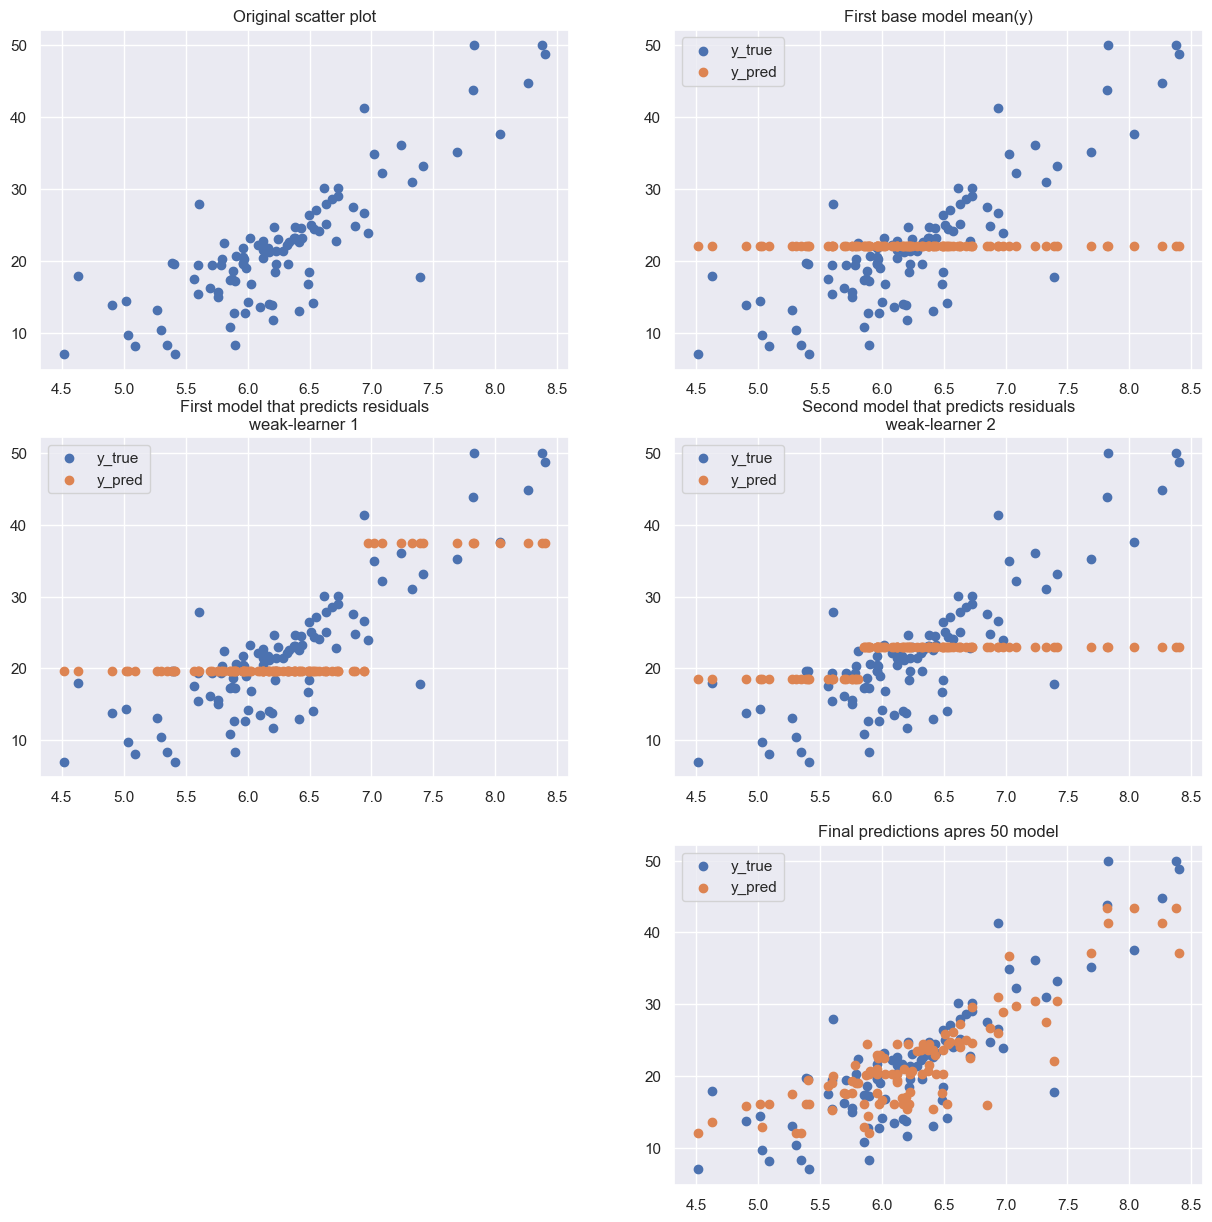

In [29]:
plt.tight_layout
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.title("Original scatter plot")
plt.scatter(X_test.iloc[:,5],y_test)
plt.subplot(3,2,2)
plt.title("First base model mean(y)")
plt.scatter(X_test.iloc[:,5],y_test)
plt.scatter(X_test.iloc[:,5],[np.mean(y_test) for i in range(0,102)])
plt.legend(['y_true',"y_pred"])
plt.subplot(3,2,3)
plt.title("First model that predicts residuals\nweak-learner 1")
model1 = DecisionTreeRegressor(max_depth = 1)
model1.fit(pd.DataFrame(X_train.iloc[:,5]),y_train-[np.mean(y_train) for i in range(0,404)])
plt.scatter(X_test.iloc[:,5],y_test)
plt.scatter(X_test.iloc[:,5],[np.mean(y_test) for i in range(0,102)]+model1.predict(pd.DataFrame(X_test.iloc[:,5])))
plt.legend(['y_true',"y_pred"])
plt.subplot(3,2,6)
plt.title("Final predictions apres 50 model")
plt.scatter(X_test.iloc[:,5],y_test)
plt.scatter(X_test.iloc[:,5],model.predict(X_test))
plt.legend(['y_true',"y_pred"])
plt.subplot(3,2,4)
plt.title("Second model that predicts residuals\n weak-learner 2")
model1.fit(pd.DataFrame(X_train.iloc[:,5]),y_train-([np.mean(y_train) for i in range(0,404)]+model1.predict(pd.DataFrame(X_train.iloc[:,5]))))
plt.scatter(X_test.iloc[:,5],y_test)
plt.scatter(X_test.iloc[:,5],[np.mean(y_test) for i in range(0,102)]+model1.predict(pd.DataFrame(X_test.iloc[:,5])))
plt.legend(['y_true',"y_pred"]);